# INCAWrapper validation case small toy model
This notebook serves as a validation case the show that the INCAWrapper produce similar results as a model run through the INCA GUI. Furthermore, this notebook can be used as an integration test of the INCAWrapper that can be run when changes are made to the codebase to ensure that the INCAWrapper performs consistently. This notebook is not meant as a tutorial and therefore code description is a bit more sparse. For a proper tutorial see the other examples at https://incawrapper.readthedocs.io/en/latest/examples/index.html.

## Introduction
In this validation case, we will use a simple toy model has been used in the literature to study 13C-MFA [1], [2]. The model contains 5 reactions and 6 metabolites. To ensure that we can obtain a good fits to the data, we employ a simulated dataset for this validation. The simulated dataset holds one experiment in which the network is fed a labelled version of the metabolite A ([2-C13]-A). In contrast the the validation case for a medium size model, we do not add measurements noise the simulated measurement for this validation case. For more details about the simulation see the simulation script at `docs/examples/Literature data/simple model/simple_model_inst_simulation.py`.

## Method for INCA GUI based flux estimation
The model, experiments and data was manually entered into the INCA GUI. This model was saved to a file (`docs/examples/Literature data/simple model/simple_model_inst_gui.mat`). We then ran first the estimate and second the continuation procedure before saving the "fluxmap" to a difference file (`docs/examples/Literature data/simple model/simple_model_inst_gui_flux_map.mat`).

## Note about randomness in INCA
When INCA estimates the flux distribution it deploys an optimisation algorithm, which searches for a local optimum in the parameter space. To increase the probability that the found flux distribution is a global optimum INCA can be configured to restart the optimisation algorithm at different point in the parameter space. Unfortunately, the INCA manual do not describe any method to set the random seed for random restarts, thus the best we can do is to a large number of restarts in both the INCA GUI and the INCAWrapper to improve the probability that the two executions finds the same optimum. Therefore, we used 1000 restarts during flux estimation in both the INCAWrapper and the INCA GUI.

## Setting up the environment
First, we will setup the coding environment, load packages, set pah to files and read-in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import incawrapper
import ast
PROJECT_DIR = pathlib.Path().cwd().parents[1].resolve()
data_folder = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model")

In [2]:
tracers_data = pd.read_csv(data_folder / "tracers.csv", 
   converters={'atom_mdv':ast.literal_eval, 'atom_ids':ast.literal_eval} # a trick to read lists from csv
).query("experiment_id == 'exp1'") # we only simulated experiment 1

reactions_data = pd.read_csv(data_folder / "reactions.csv")
ms_data = pd.read_csv(data_folder / 'simulated_data' / "mdv_noisy.csv", 
   converters={'labelled_atom_ids': ast.literal_eval} # a trick to read lists from csv
)
pool_sizes = pd.read_csv(data_folder / 'simulated_data' / "pool_sizes_measurement_noisy.csv")
flux_measurements = pd.read_csv(data_folder / 'simulated_data' / "flux_measurements_noisy.csv")

# fluxmap files
output_file = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model/simple_model_inst_gui_flux_map.mat")
flux_map_gui_file = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model/simple_model_inst_gui_flux_map.mat")


We consider one experiment with a single labelled substrate, A, which is labelled at carbon position 2.

In [3]:
tracers_data.head()

,experiment_id,met_id,tracer_id,atom_ids,ratio,atom_mdv,enrichment
0,exp1,A,[2-13C]A,[2],1.0,"[0, 1]",1


## Setup the INCAScript
We will now setup and run INCA. Notice that we set fit_restarts=1000, this increase the chance that the two optimization runs (GUI and INCAWrapper) find the same optimum.

In [4]:
script = incawrapper.create_inca_script_from_data(
    reactions_data=reactions_data, 
    tracer_data=tracers_data, 
    flux_measurements=flux_measurements,
    pool_measurements=pool_sizes,
    ms_measurements=ms_data, 
    experiment_ids=["exp1"]
)
script.add_to_block("options", 
    incawrapper.define_options(
        fit_starts=1000, # Number of flux estimation restarts
        sim_na=False, # Do not simulate natural abundance
        sim_ss=False # Do INST 13C MFA
    )
)
script.add_to_block("runner", incawrapper.define_runner(output_file, run_estimate=True, run_continuation=True))

Now the script is ready to run in matlab.

In [5]:
import dotenv
inca_directory = pathlib.Path(dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory"))
incawrapper.run_inca(script, INCA_base_directory=inca_directory)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmp26vq5j5t/inca_script.m.
Starting MATLAB engine...
 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
m = 1x1 model object
 
fields: [expts]  [mets]  notes  [options]  [rates]  [states]  
 
	5 reactions (6 fluxes)                                  
	6 states (3 balanced, 1 source, 2 sink and 0 unbalanced)
	6 metabolites                                           
	1 experiments                                           
 

                                         Directional 
 Iteration      Residual     Step-size    derivative        Lambda
     0       8.47572e+07
     1        1.6752e+07         0.567     -3.64e+07      0.159909
     2       1.66471e+07       0.00318     -1.65e+07      0.159909
  

We can now read the results from INCA using the `INCAResults` object.

In [6]:
# read in the fitted fluxes
res = incawrapper.INCAResults(output_file)

# load the fluxmap from the GUI run
res_gui = incawrapper.INCAResults(flux_map_gui_file)

# Print fit accepted status
print("INCA GUI goodness of fit:\n")
res_gui.fitdata.get_goodness_of_fit()
print("\n")
print("INCAWrapper goodness of fit:\n")
res.fitdata.get_goodness_of_fit()

INCA GUI goodness of fit:

Fit accepted: True
Confidence level: 0.05
Chi-square value (SSR): 35.488762845190905
Expected chi-square range: [17.53873858 48.23188959]


INCAWrapper goodness of fit:

Fit accepted: True
Confidence level: 0.05
Chi-square value (SSR): 35.40149610837736
Expected chi-square range: [17.53873858 48.23188959]


We see that the SSR value is below the expected range, thus this indicate that we are overfitting the data. However, in this scenario it is not surprising, because we used the exact simulated values with out measurement noise.

We can compare the SSR values from the to solutions more directly here

In [7]:
## Compare the SSR values
print("INCA GUI SSR: " + str(res_gui.fitdata.chi2))
print("INCAWrapper SSR: " + str(res.fitdata.chi2))
print("SSR difference: " + str(res_gui.fitdata.chi2 - res.fitdata.chi2))

INCA GUI SSR: 35.488762845190905
INCAWrapper SSR: 35.40149610837736
SSR difference: 0.08726673681354669


We see that the SSR values match down the 6th decimal point. Now lets compare the fitted flux distributions

In [8]:
# Merging the two solutions in one dataframe and calculating the difference between the two solutions
fitted_parameters_compare = pd.merge(
    # the estimated norm values (the scale factor for the MDVs) has some empty arrays in some cells, these are replaced with NaNs
    left=res.fitdata.fitted_parameters.applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x),
    right=res_gui.fitdata.fitted_parameters.applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x),
    on=['type','id'],
    suffixes=('_from_incawrapper', '_from_gui'),
    validate='one_to_one',
).assign(
    val_diff = lambda x: np.abs(x['val_from_incawrapper'] - x['val_from_gui']),
    lb_diff = lambda x: np.abs(x['lb_from_incawrapper'] - x['lb_from_gui']),
    ub_diff = lambda x: np.abs(x['ub_from_incawrapper'] - x['ub_from_gui']),
)

Here we setup a visual comparison of the flux distributions.

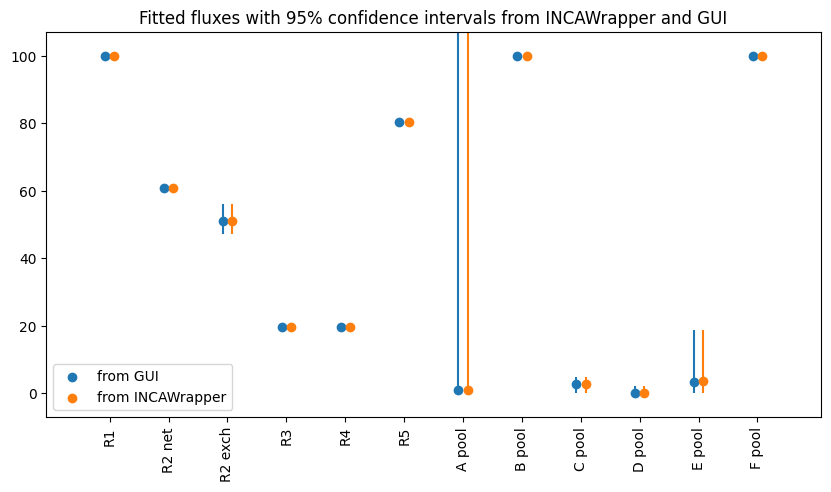

In [9]:
# set up parameters for the aestitics of the plot
data_max = fitted_parameters_compare[['val_from_incawrapper', 'val_from_gui']].max().max()
data_min = fitted_parameters_compare[['val_from_incawrapper', 'val_from_gui']].min().min()
yaxis_range = [data_min - 7, data_max + 7]
offset = 0.08

# Prepare the data for plotting. We only want to plot the fluxes 
# and the undetermined confidence interval bounds are set the the axis boundaries
plot_df = (fitted_parameters_compare
    .query("type.str.contains('flux|Pool')")
    .replace({
        'lb_from_incawrapper': {
            -np.inf: yaxis_range[0],
            np.inf: yaxis_range[0],
            np.nan: yaxis_range[0]
        },
        'lb_from_gui': {
            -np.inf: yaxis_range[0],
            np.nan: yaxis_range[0],
            np.inf: yaxis_range[0]
        },
        'ub_from_incawrapper': {
            -np.inf: yaxis_range[1],
            np.nan: yaxis_range[1],
            np.inf: yaxis_range[1]
        },
        'ub_from_gui': {
            -np.inf: yaxis_range[1],
            np.nan: yaxis_range[1],
            np.inf: yaxis_range[1]
        }
    }).copy()
)
fig, ax = plt.subplots(figsize=(10, 5))

# Create numerical ids for plotting
unique_ids = plot_df['id']
id_dict = {id: i for i, id in enumerate(unique_ids)}
plot_df['num_id'] = plot_df['id'].map(id_dict)

# Calculate error bars for both dataframes
errbars1 = plot_df[['lb_from_gui', 'ub_from_gui']].subtract(plot_df['val_from_gui'], axis=0).abs().T
errbars2 = plot_df[['lb_from_incawrapper', 'ub_from_incawrapper']].subtract(plot_df['val_from_incawrapper'], axis=0).abs().T

# Plot fitted values and error bars for the first dataframe
ax.scatter(x=plot_df['num_id'] - offset, y=plot_df['val_from_gui'], color='C0', label='from GUI')
ax.errorbar(x=plot_df['num_id'] - offset, y=plot_df['val_from_gui'], yerr=errbars1, color='C0', fmt='none')

# Plot fitted values and error bars for the second dataframe
ax.scatter(x=plot_df['num_id'] + offset, y=plot_df['val_from_incawrapper'], color='C1', label='from INCAWrapper')
ax.errorbar(x=plot_df['num_id'] + offset, y=plot_df['val_from_incawrapper'], yerr=errbars2, color='C1', fmt='none')

# Rotate x-axis labels and set them to the original string ids
ax.set_xticks(range(len(unique_ids)))
ax.set_xticklabels(unique_ids, rotation=90)

ax.legend()
ax.set_ylim(yaxis_range)
ax.set_xlim(plot_df['num_id'].min() - offset - 1, plot_df['num_id'].max() + offset + 1)
ax.set_title("Fitted fluxes with 95% confidence intervals from INCAWrapper and GUI")

plt.show()

Both for the fluxes and the pool sizes that GUI and the INCAWrapper solution align very well. This applies both for the "best estimate" value and the confidence intervals. We see that for the current dataset the pool size of A is non-determinable.

Let's investigate the differences between the two solutions.

/Users/s143838/.virtualenvs/incawrapper-dev/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/s143838/.virtualenvs/incawrapper-dev/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


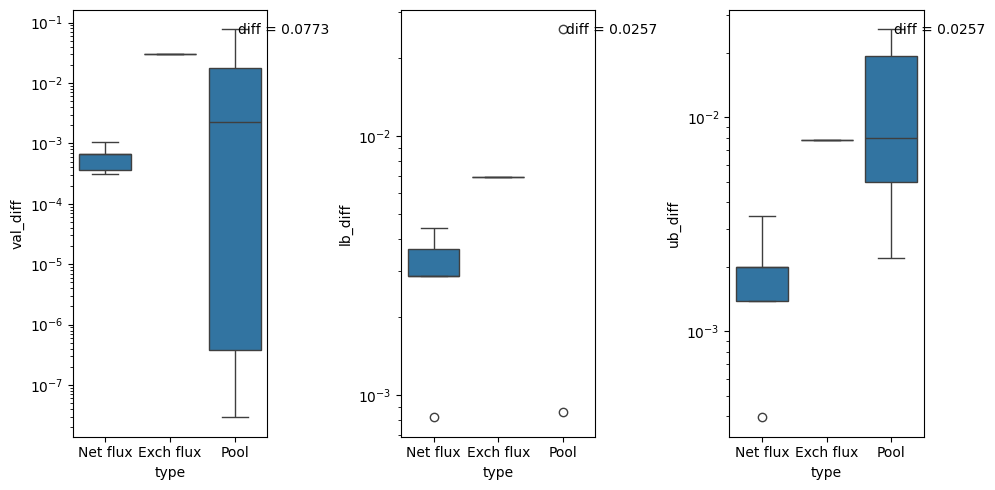

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, quantity in enumerate(['val', 'lb', 'ub']):
    sns.boxplot(
        data=fitted_parameters_compare.dropna(subset=[f'{quantity}_diff']), 
        x='type', 
        y=f'{quantity}_diff',
        ax=axes[i],
        log_scale=True, 
    )

    # Annotate the largest difference in the exchange fluxes
    max_diff_exch = fitted_parameters_compare.loc[fitted_parameters_compare[f'{quantity}_diff'].idxmax()]
    axes[i].annotate(
        "diff = " + str(max_diff_exch['val_diff'].round(4)),
        (max_diff_exch['type'], max_diff_exch[f'{quantity}_diff']),
        textcoords="offset points",
        xytext=(35,-3),
        ha='center',
    )
plt.tight_layout()
plt.show()

We see that the differences between the estimated parameters is less the 0.1 flux or pool size units. For most parameters the differences are even an order of magnitude smaller.

## Conclusion


The solution obtained through the INCAWrapper and the INCA GUI align very well, however, it is expected that the two estimates do not match exactly due the inability to control the random seed in INCA, which was described in the introduction. 

## References
[1] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Determination of confidence intervals of metabolic fluxes estimated from stable isotope measurements,” Metabolic Engineering, vol. 8, no. 4, pp. 324–337, Jul. 2006, doi: 10.1016/j.ymben.2006.01.004.

[2] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Elementary metabolite units (EMU): A novel framework for modeling isotopic distributions,” Metabolic Engineering, vol. 9, no. 1, pp. 68–86, Jan. 2007, doi: 10.1016/j.ymben.2006.09.001.
